Debemos preparar datos, probar varios modelos, preseleccionar los mejores, ajustar sus hiperparámetros usando GridSearchCV y automatizar todo lo posible

# Dataset

https://www.kaggle.com/datos_estudiantessets/kundanbedmutha/exam-score-prediction-dataset?resource=download

# Imports
Importamos todos lso elementos que usaremos a lo largo del notebook. También, definimos la semilla utilizada para que todas las ejecuciones tengan el mismo resultado

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import io

from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Definimos la semilla
np.random.seed(42)

# Carga del dataset

In [46]:
datos_estudiantes = pd.read_csv("Datasets/Exam_Score_Prediction.csv", sep=',', index_col="student_id")
datos_estudiantes.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
student_id,,,,,,,,,,,,
1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


# Selección y extracción de atributos

Vamos a comenzar reduciendo el número de atributos de nuestra dataset, lo cual es muy importante para evitar la maldición de la dimensionalidad (curse of dimensionality). En caso contrario, los efetos serían:

- Cuando aumenta la dimensionalidad, el volumen del espacio aumenta exponencialmente haciendo que los datos disponibles se vuelvan dispersos. 
- Esta dispersión impide que los algoritmos de aprendizaje puedan construir buenos modelos.

La estrategias que utilizaremos para luchar contra la maldición de la dimensionalidad sonla selección y extracción de atributos. 

En primer lugar, construiremos nuevos atributos a partir de los originales.Posteriormente, seleccionaremos un buen conjunto de atributos. 

In [47]:
#Creamos un atributo para saber si han aprobado
datos_estudiantes['passed']=datos_estudiantes['exam_score']>=50.00

#Creamos un atributo para saber si la calificación obtenida es failed, passed, good, merit o excellent
def calculo_calificacion_estudiante(estudiante):
    if (estudiante.loc['exam_score']<50.00):
        return 'failed'
    elif (estudiante.loc['exam_score']<60.00):
        return 'passed'
    elif (estudiante.loc['exam_score']<70.00):
        return 'good'
    elif (estudiante.loc['exam_score']<90.00):
        return 'merit'
    else:
        return 'Excellent'
    
datos_estudiantes['mark']=datos_estudiantes.apply(lambda datos_estudiantes:calculo_calificacion_estudiante(datos_estudiantes), axis=1)

datos_estudiantes

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9,True,passed
2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8,True,passed
3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3,True,Excellent
4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7,False,failed
5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7,False,failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,18,other,bba,6.50,71.3,yes,5.0,good,self-study,low,easy,86.5,True,merit
19998,18,male,b.com,3.71,41.6,no,5.9,average,coaching,medium,moderate,60.9,True,good
19999,19,other,diploma,7.88,68.2,yes,4.6,poor,group study,low,easy,64.5,True,good


A continuación, para poder utilizar los algoritmos, preprocesamos el dataframe datos_estudiantes para tener exclusivamente datos numéricos

In [49]:
def preprocesamiento_calificaciones(datos_estudiantes):
    if datos_estudiantes['mark']=='failed':
        m=0
    elif datos_estudiantes['mark']=='passed':
        m=1
    elif datos_estudiantes['mark']=='good':
        m=2
    elif datos_estudiantes['mark']=='merit':
        m=3
    else:
        m=4
    datos_estudiantes['mark']=m
    return datos_estudiantes
    

datos_estudiantes = datos_estudiantes.apply(preprocesamiento_calificaciones, axis=1)
datos_estudiantes

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9,True,1
2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8,True,1
3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3,True,4
4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7,False,0
5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,18,other,bba,6.50,71.3,yes,5.0,good,self-study,low,easy,86.5,True,3
19998,18,male,b.com,3.71,41.6,no,5.9,average,coaching,medium,moderate,60.9,True,2
19999,19,other,diploma,7.88,68.2,yes,4.6,poor,group study,low,easy,64.5,True,2


Para evitar realizar este trabajo manualmente, utilizaremos la función LabelEncoder() de scikitLearn, que nos ayudará a transformar todos los valores de un atributo a números

Para cada atributo, seguimos el siguiente proceso:
1. Generamos el encoder.
2. Ajustamos el encoder al atributo.
3. Transformamos los valores a numérico.
4. Imprimimos en consola un mensaje para saber qué atributo se está transformando
5. 

In [50]:
gender_encoder = LabelEncoder()
gender_encoder.fit(datos_estudiantes['gender'])
datos_estudiantes['gender'] = gender_encoder.transform(datos_estudiantes['gender'])
print("Codificamos el género")
print(list(gender_encoder.classes_))
print(gender_encoder.transform(gender_encoder.classes_))

course_encoder = LabelEncoder()
course_encoder.fit(datos_estudiantes['course'])
datos_estudiantes['course'] = course_encoder.transform(datos_estudiantes['course'])
print("\nCourse codification")
print(list(course_encoder.classes_))
print(course_encoder.transform(course_encoder.classes_))

internet_access_encoder = LabelEncoder()
internet_access_encoder.fit(datos_estudiantes['internet_access'])
datos_estudiantes['internet_access'] = internet_access_encoder.transform(datos_estudiantes['internet_access'])
print("\nCourse codification")
print(list(internet_access_encoder.classes_))
print(internet_access_encoder.transform(internet_access_encoder.classes_))

sleep_quality_encoder = LabelEncoder()
sleep_quality_encoder.fit(datos_estudiantes['sleep_quality'])
datos_estudiantes['sleep_quality'] = sleep_quality_encoder.transform(datos_estudiantes['sleep_quality'])
print("\nSleep Quality codification")
print(list(sleep_quality_encoder.classes_))
print(sleep_quality_encoder.transform(sleep_quality_encoder.classes_))

study_method_encoder = LabelEncoder()
study_method_encoder.fit(datos_estudiantes['study_method'])
datos_estudiantes['study_method'] = study_method_encoder.transform(datos_estudiantes['study_method'])
print("\nStudy Method codification")
print(list(study_method_encoder.classes_))
print(study_method_encoder.transform(study_method_encoder.classes_))

facility_rating_encoder = LabelEncoder()
facility_rating_encoder.fit(datos_estudiantes['facility_rating'])
datos_estudiantes['facility_rating'] = facility_rating_encoder.transform(datos_estudiantes['facility_rating'])
print("\nFacility Rating codification")
print(list(facility_rating_encoder.classes_))
print(facility_rating_encoder.transform(facility_rating_encoder.classes_))

exam_difficulty_encoder = LabelEncoder()
exam_difficulty_encoder.fit(datos_estudiantes['exam_difficulty'])
datos_estudiantes['exam_difficulty'] = exam_difficulty_encoder.transform(datos_estudiantes['exam_difficulty'])
print("\nExam Difficulty codification")
print(list(exam_difficulty_encoder.classes_))
print(exam_difficulty_encoder.transform(exam_difficulty_encoder.classes_))

passed_encoder = LabelEncoder()
passed_encoder.fit(datos_estudiantes['passed'])
datos_estudiantes['passed'] = passed_encoder.transform(datos_estudiantes['passed'])
print("\nExam Difficulty codification")
print(list(passed_encoder.classes_))
print(passed_encoder.transform(passed_encoder.classes_))

Codificamos el género
['female', 'male', 'other']
[0 1 2]

Course codification
['b.com', 'b.sc', 'b.tech', 'ba', 'bba', 'bca', 'diploma']
[0 1 2 3 4 5 6]

Course codification
['no', 'yes']
[0 1]

Sleep Quality codification
['average', 'good', 'poor']
[0 1 2]

Study Method codification
['coaching', 'group study', 'mixed', 'online videos', 'self-study']
[0 1 2 3 4]

Facility Rating codification
['high', 'low', 'medium']
[0 1 2]

Exam Difficulty codification
['easy', 'hard', 'moderate']
[0 1 2]

Exam Difficulty codification
[np.False_, np.True_]
[0 1]


In [51]:
datos_estudiantes.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,1,6,2.78,92.9,1,7.4,2,0,1,1,58.9,1,1
2,23,2,5,3.37,64.8,1,4.6,0,3,2,2,54.8,1,1
3,22,1,1,7.88,76.8,1,8.5,2,0,0,2,90.3,1,4
4,20,2,6,0.67,48.4,1,5.8,0,3,1,2,29.7,0,0
5,20,0,6,0.89,71.6,1,9.8,2,0,1,2,43.7,0,0


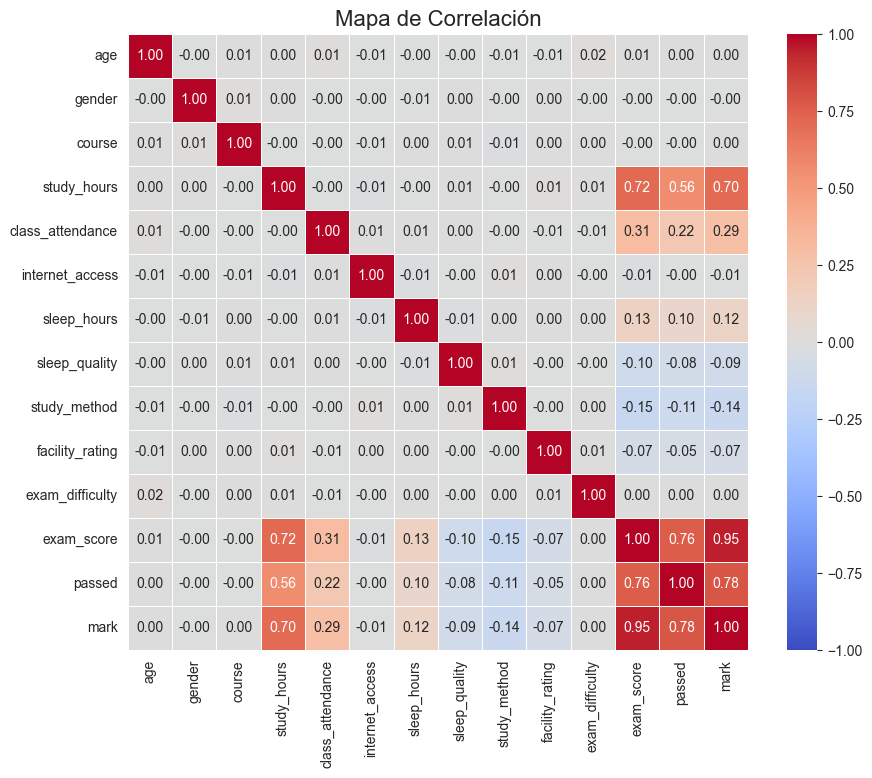

In [52]:
matriz_correlacion = datos_estudiantes.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Mapa de Correlación', fontsize=16)
plt.show()

# Clasificación

Las tareas de clasificación pertenecen al aprendizaje supervisado y consisten en predecir la clase a la que pertenece un individuo.

El conjunto de datos seleccionado contiene información sobre datos académicos, hábitos y la rutina de 20.000 estudiantes de entre 17 y 24 años. Esta información nos permitirá entender cómo diferentes aspectos en la vida de un estudiante afectan a su rendimiento académico.

En concreto, los 13 atributos son los siguientes:

* Student_id: identificador único del estudiante (1 - 20.000)
* Age: edad (17 - 24 años)
* Gender: género (male, female, other)
* Course: curso de estudio.
  * Diploma: Formación Profesional
  * Bachelor of Computer Aplications (BCA): grado de aplicaciones de computación, aplicado a la informática y desarrollo de software
  * Bachelor of Science (B.Sc): grado de ciencias (sin especificar la especialidad)
  * Bachelor of Technology (B.Tech): ingeniería
  * Bachelor of Business Administration (BBA): grado en administración de empresas
  * Bachelor of Arts: grado en artes o humanidades.
  * Bachelor of Commerce (B.Com): grado en comercio, contabilidad o finanzas
* Study_hours: horas de estudio (0.00 - 7.91)
* Class_attendance: porcentaje de asistencia a clases (40.6 - 99.4)
* Internet_access: acceso a internet (true/false)
* Sleep_hours: Horas de sueño diarias (4.1 - 9.9)
* Sleep_quality: Calidad del sueño (poor, average, good)
* Study_method: método de estudio (self-study, online videos, coaching, group study, mixed)
* Facility_rating: valoración del lugar de estudio (low, medium, high)
* Exam_difficulty: dificultad del examen (easy, moderate, high)
* Exam_score: puntuación en el examen (0.00 - 100.00)
* Nueva columna: calificación --> failed, passed, good, merit, excellent

Nuestro objetivo es que, gracias a estos atributos que comprenden un amplio espectro de influencias observadas comúnmente en ambientes académicos, podamos entender con facilidad qué aspectos son más importantes en el rendimiento académico.

En concreto, se van a responder las siguientes preguntas:

* ¿Qué perfiles existen?
* ¿Qué modelo ofrece una mayor precisión para la predicción de exam_difficulty, facility_rating, study_method, sleep_quality, internet_access, course o gender?
* Se observa algo interesante entre sleep_quality y sleep_hours
* Qué atributos tienen más importancia y cómo el rendimiento al no usar exam_difficulty para evitar depender de la dificultad del examen
* Qué importancia tiene asistencia frente a horas de estudio para clasificar "calificación"
* ¿Qué comportamiento aparece al introducir variables derivadas como 'ratio de estudio - sueño' o 'índice de hábito'?
* Qué reglas extrae un árbol
* ¿Se mantiene el rendimiento al excluir algún curso del entrenamiento y test?
* ¿Cómo de robusto es el modelo a valores extremos o inconsistentes (outliers)?
* ¿Qué sucede si faltan datos en sleep_quality o internet_Access y se imputa?
* ¿Se cumple una igualdad entre subgrupos para la clase clasificación?
* Qué impacto tiene eliminar el género sobre el rendimiento global
* ¿Qué patrones caracterizan a los falsos positivos y falsos negativos?
* ¿Se concentran los falsos positivo/negativo en estudiantes con calificaciones excelentes?
* Cómo queda la matriz de confusión con las calificaciones?
* ¿Hay alguna métrica más informativa que el accuracy?
  
Hemos dado:
* Clasificación binaria
* Validación cruzada
* curva precisión/cobertura
* análisis ROC y AUC
* clasificación multiclase
* Análisis de errores. 
* Clasificación multietiqueta
* Clasificadores en cadena. Entrenar un clasificador por etiqueta y componer secuencialmente los clasificadores
* KNN
* Kmeans



# Redes Neuronales

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().set_output(transform="pandas")
datos_estudiantes_scaled = scaler.fit_transform(datos_estudiantes)
datos_estudiantes_scaled.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,0.000000,0.5,1.000000,0.344828,0.889456,1.0,0.568966,1.0,0.00,0.5,0.5,0.488812,1.0,0.25
2,0.857143,1.0,0.833333,0.420179,0.411565,1.0,0.086207,0.0,0.75,1.0,1.0,0.437818,1.0,0.25
3,0.714286,0.5,0.166667,0.996169,0.615646,1.0,0.758621,1.0,0.00,0.0,1.0,0.879355,1.0,1.00
4,0.428571,1.0,1.000000,0.075351,0.132653,1.0,0.293103,0.0,0.75,0.5,1.0,0.125633,0.0,0.00
5,0.428571,0.0,1.000000,0.103448,0.527211,1.0,0.982759,1.0,0.00,0.5,1.0,0.299760,0.0,0.00


## Regresion

In [58]:
from sklearn.model_selection import train_test_split

X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)
y = datos_estudiantes_scaled['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [64]:
import tensorflow as tf

nivel_oculto1 = tf.keras.layers.Dense(30, activation="relu")
nivel_oculto2 = tf.keras.layers.Dense(30, activation="relu")
nivel_union = tf.keras.layers.Concatenate()
nivel_salida = tf.keras.layers.Dense(1)

entrada = tf.keras.layers.Input(shape=X_train.shape[1:])
oculto1 = nivel_oculto1(entrada)
oculto2 = nivel_oculto2(oculto1)
salida = nivel_salida(oculto2)

modelo1 = tf.keras.Model(inputs=[entrada], outputs=[salida])

In [65]:
optimizador = tf.keras.optimizers.Adam(learning_rate=1e-3) #learning_rate=1e-3
modelo1.compile(optimizer=optimizador, loss="mse",  metrics=["RootMeanSquaredError"])

In [62]:
n_iter = 50
history1 = modelo1.fit(X_train, y_train, epochs=n_iter,
                    validation_data=(X_test, y_test))

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - RootMeanSquaredError: 0.1829 - loss: 0.0334 - val_RootMeanSquaredError: 0.1372 - val_loss: 0.0188
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1353 - loss: 0.0183 - val_RootMeanSquaredError: 0.1323 - val_loss: 0.0175
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1324 - loss: 0.0175 - val_RootMeanSquaredError: 0.1328 - val_loss: 0.0176
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1300 - loss: 0.0169 - val_RootMeanSquaredError: 0.1294 - val_loss: 0.0167
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1278 - loss: 0.0163 - val_RootMeanSquaredError: 0.1281 - val_loss: 0.0164
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1272 - loss: 0.0162 - val_RootMeanSquaredError: 0.1258 - val_loss: 0.0158
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1267 - los

dict_keys(['RootMeanSquaredError', 'loss', 'val_RootMeanSquaredError', 'val_loss'])
[0.18285542726516724, 0.1352505385875702, 0.13239417970180511, 0.12999773025512695, 0.127787783741951, 0.12722626328468323, 0.12665963172912598, 0.12584392726421356, 0.12525033950805664, 0.12519784271717072, 0.12469439953565598, 0.125180184841156, 0.12436110526323318, 0.12468127906322479, 0.12441731989383698, 0.12475884705781937, 0.12443368136882782, 0.12445546686649323, 0.12382959574460983, 0.1240726113319397, 0.12369353324174881, 0.12413550168275833, 0.1235639899969101, 0.12371721118688583, 0.12347903847694397, 0.12317360192537308, 0.12335443496704102, 0.12330400943756104, 0.12334591150283813, 0.12324962764978409, 0.12304070591926575, 0.12312664836645126, 0.12305282056331635, 0.12312284857034683, 0.12312930077314377, 0.12336483597755432, 0.12263321876525879, 0.12262081354856491, 0.12255260348320007, 0.12248023599386215, 0.1228322684764862, 0.12247823178768158, 0.12267232686281204, 0.12230479717254639,

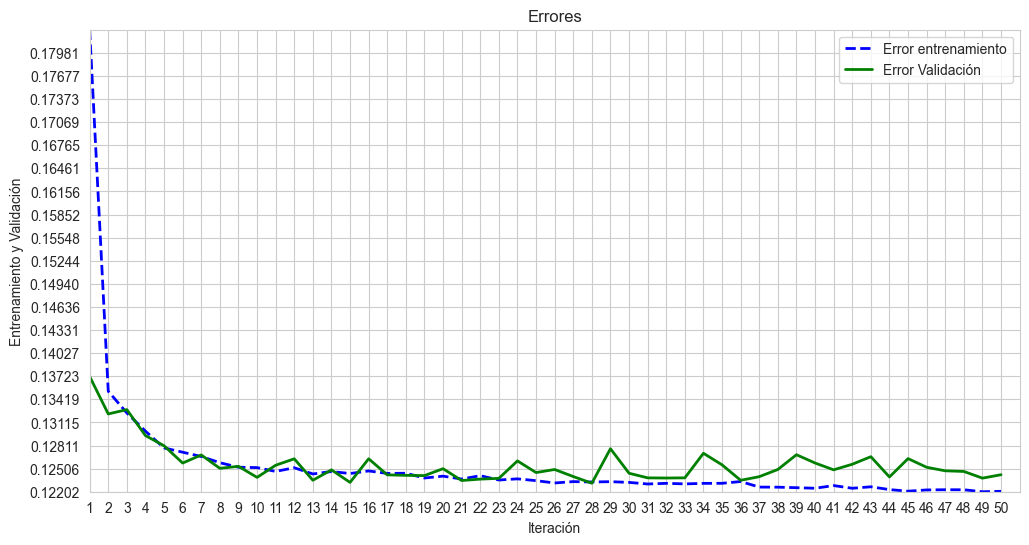

In [63]:
import numpy as np
errores_entrenamiento = history1.history['RootMeanSquaredError']
errores_validacion = history1.history['val_RootMeanSquaredError']
print(history1.history.keys())
print(errores_entrenamiento)
print(errores_validacion)

min_errores_entrenamiento = np.min(errores_entrenamiento)
min_errores_validacion = np.min(errores_validacion)
min = np.min([min_errores_entrenamiento,min_errores_validacion])

max_errores_entrenamiento = np.max(errores_entrenamiento)
max_errores_validacion = np.max(errores_validacion)
max = np.max([max_errores_entrenamiento,max_errores_validacion])



import matplotlib.pyplot as plt


iteraciones = np.arange(1, n_iter+1, 1)

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.grid(True)
ax.axis((1, n_iter+1, min, max))
ax.set_xticks(iteraciones)
ax.set_yticks(np.arange(min, max, (max-min)/20))

ax.plot(iteraciones, errores_entrenamiento, "b--", label="Entrenamiento", linewidth=2)
ax.plot(iteraciones, errores_validacion, "g-", label="Validación", linewidth=2)

ax.legend(["Error entrenamiento", "Error Validación"])

plt.title('Errores')
plt.xlabel('Iteración')
plt.ylabel('Entrenamiento y Validación')
plt.show()

## Clasificacion

In [66]:
from sklearn.model_selection import train_test_split

X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)
y = datos_estudiantes_scaled['mark']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - RootMeanSquaredError: 0.2259 - loss: 0.0510 - val_RootMeanSquaredError: 0.2119 - val_loss: 0.0449
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.2032 - loss: 0.0413 - val_RootMeanSquaredError: 0.2028 - val_loss: 0.0411
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1980 - loss: 0.0392 - val_RootMeanSquaredError: 0.1996 - val_loss: 0.0398
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1960 - loss: 0.0384 - val_RootMeanSquaredError: 0.1980 - val_loss: 0.0392
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1944 - loss: 0.0378 - val_RootMeanSquaredError: 0.1988 - val_loss: 0.0395
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1935 - loss: 0.0374 - val_RootMeanSquaredError: 0.1983 - val_loss: 0.0393
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1931 - los

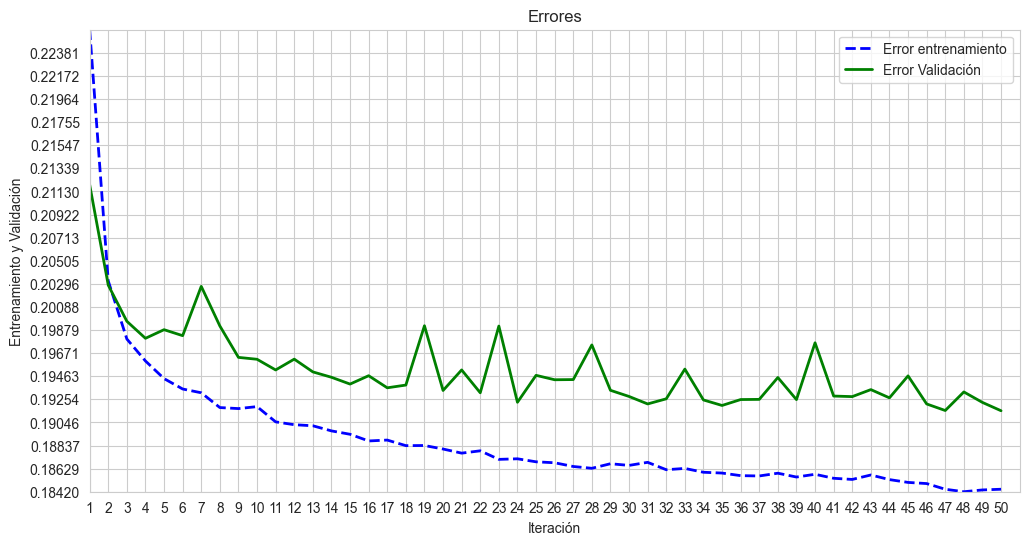

In [67]:
import tensorflow as tf


nivel_oculto1 = tf.keras.layers.Dense(30, activation="relu")
nivel_oculto2 = tf.keras.layers.Dense(30, activation="relu")
nivel_union = tf.keras.layers.Concatenate()
nivel_salida = tf.keras.layers.Dense(1)

entrada = tf.keras.layers.Input(shape=X_train.shape[1:])
oculto1 = nivel_oculto1(entrada)
oculto2 = nivel_oculto2(oculto1)
salida = nivel_salida(oculto2)

modelo1 = tf.keras.Model(inputs=[entrada], outputs=[salida])
optimizador = tf.keras.optimizers.Adam(learning_rate=1e-3)  #learning_rate=1e-3
modelo1.compile(optimizer=optimizador, loss="mse", metrics=["RootMeanSquaredError"])
n_iter = 50
history1 = modelo1.fit(X_train, y_train, epochs=n_iter,
                       validation_data=(X_test, y_test))
import numpy as np


errores_entrenamiento = history1.history['RootMeanSquaredError']
errores_validacion = history1.history['val_RootMeanSquaredError']
print(history1.history.keys())
print(errores_entrenamiento)
print(errores_validacion)

min_errores_entrenamiento = np.min(errores_entrenamiento)
min_errores_validacion = np.min(errores_validacion)
min = np.min([min_errores_entrenamiento, min_errores_validacion])

max_errores_entrenamiento = np.max(errores_entrenamiento)
max_errores_validacion = np.max(errores_validacion)
max = np.max([max_errores_entrenamiento, max_errores_validacion])

import matplotlib.pyplot as plt


iteraciones = np.arange(1, n_iter + 1, 1)

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.grid(True)
ax.axis((1, n_iter + 1, min, max))
ax.set_xticks(iteraciones)
ax.set_yticks(np.arange(min, max, (max - min) / 20))

ax.plot(iteraciones, errores_entrenamiento, "b--", label="Entrenamiento", linewidth=2)
ax.plot(iteraciones, errores_validacion, "g-", label="Validación", linewidth=2)

ax.legend(["Error entrenamiento", "Error Validación"])

plt.title('Errores')
plt.xlabel('Iteración')
plt.ylabel('Entrenamiento y Validación')
plt.show()